# Find Largest Wildfire Samples

This notebook searches through all NetCDF files in the dataset and ranks them by burned area.
Useful for finding the most severe wildfire events for testing and visualization.

In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd

print("Imports successful!")

Imports successful!


## 1. Configure Search Parameters

In [2]:
# Configuration
DATA_DIR = Path('../data/raw/dataset_64_64_all_10days_final/2022')
TOP_N = 10  # Number of top fires to find

print(f"Searching for largest fires in: {DATA_DIR}")
print(f"Will find top {TOP_N} samples by burned area")

Searching for largest fires in: ../data/raw/dataset_64_64_all_10days_final/2022
Will find top 10 samples by burned area


## 2. Find All NetCDF Files

In [3]:
# Recursively find all .nc files in the directory
nc_files = sorted(list(DATA_DIR.rglob('*.nc')))

print(f"Found {len(nc_files)} NetCDF files")

if len(nc_files) == 0:
    print("\n⚠️  ERROR: No NetCDF files found!")
    print(f"Please check the path: {DATA_DIR.absolute()}")
else:
    print(f"\nFirst few files:")
    for f in nc_files[:5]:
        print(f"  - {f.relative_to(DATA_DIR.parent)}")

Found 1102 NetCDF files

First few files:
  - 2022/Albania/corrected_sample_10067.nc
  - 2022/Albania/corrected_sample_10069.nc
  - 2022/Albania/corrected_sample_10076.nc
  - 2022/Albania/corrected_sample_10078.nc
  - 2022/Albania/corrected_sample_10085.nc


## 3. Extract Burned Area Information

In [4]:
# Collect burned area information from all files
print("Extracting burned area information...")
print("=" * 80)

fire_data = []

for nc_file in tqdm(nc_files, desc="Processing files"):
    try:
        # Open dataset
        ds = xr.open_dataset(nc_file)
        
        # Get burned area from attributes
        burned_area_ha = ds.attrs.get('burned_area_ha', 0.0)
        
        # Also compute from burned_areas variable if available
        if 'burned_areas' in ds:
            burned_areas = ds['burned_areas'].values
            total_burned_pixels = (burned_areas > 0).sum()
            max_burned_day = burned_areas.sum(axis=(1, 2)).max()
        else:
            total_burned_pixels = 0
            max_burned_day = 0
        
        # Store information
        fire_data.append({
            'file_path': nc_file,
            'file_name': nc_file.name,
            'country': ds.attrs.get('country', 'Unknown'),
            'date': ds.attrs.get('date', 'Unknown'),
            'burned_area_ha': burned_area_ha,
            'total_burned_pixels': int(total_burned_pixels),
            'max_burned_day': int(max_burned_day),
            'relative_path': str(nc_file.relative_to(DATA_DIR.parent))
        })
        
        ds.close()
        
    except Exception as e:
        print(f"\n⚠️  Error processing {nc_file.name}: {e}")
        continue

print(f"\n✓ Successfully processed {len(fire_data)} files")

Extracting burned area information...


Processing files: 100%|██████████| 1102/1102 [00:05<00:00, 186.32it/s]


✓ Successfully processed 1102 files


## 4. Create DataFrame and Sort by Burned Area

In [5]:
# Create DataFrame
df = pd.DataFrame(fire_data)

# Sort by burned area (descending)
df_sorted = df.sort_values('burned_area_ha', ascending=False)

print("\nDataset Statistics:")
print("=" * 80)
print(f"Total samples: {len(df)}")
print(f"Total burned area: {df['burned_area_ha'].sum():,.2f} ha")
print(f"Average burned area: {df['burned_area_ha'].mean():,.2f} ha")
print(f"Median burned area: {df['burned_area_ha'].median():,.2f} ha")
print(f"Max burned area: {df['burned_area_ha'].max():,.2f} ha")
print(f"Min burned area: {df['burned_area_ha'].min():,.2f} ha")
print(f"\nCountries: {df['country'].nunique()}")
print(df['country'].value_counts().to_string())


Dataset Statistics:
Total samples: 1102
Total burned area: 3,890,545.00 ha
Average burned area: 3,530.44 ha
Median burned area: 1,999.00 ha
Max burned area: 56,961.00 ha
Min burned area: 375.00 ha

Countries: 26
country
Romania                                      173
Spain                                        140
Ukraine                                      128
Italy                                        121
Bosnia & Herzegovina                         103
Portugal                                      88
France                                        51
Croatia                                       44
Algeria                                       37
Montenegro                                    37
Albania                                       34
Serbia                                        32
Bulgaria                                      23
Tunisia                                       23
Greece                                        22
Morocco                                     

## 5. Display Top N Largest Fires

In [6]:
# Get top N
top_fires = df_sorted.head(TOP_N)

print(f"\n{'='*80}")
print(f"TOP {TOP_N} LARGEST WILDFIRES")
print(f"{'='*80}\n")

for i, row in top_fires.iterrows():
    print(f"#{top_fires.index.get_loc(i) + 1}. {row['file_name']}")
    print(f"   Country: {row['country']}")
    print(f"   Date: {row['date']}")
    print(f"   Burned Area: {row['burned_area_ha']:,.2f} ha")
    print(f"   Total Burned Pixels: {row['total_burned_pixels']:,}")
    print(f"   Max Burned (single day): {row['max_burned_day']:,} pixels")
    print(f"   Path: {row['relative_path']}")
    print()

print(f"{'='*80}")


TOP 10 LARGEST WILDFIRES

#1. corrected_sample_10238.nc
   Country: Spain
   Date: 2022-07-16
   Burned Area: 56,961.00 ha
   Total Burned Pixels: 491
   Max Burned (single day): 456 pixels
   Path: 2022/Spain/corrected_sample_10238.nc

#2. corrected_sample_10292.nc
   Country: Spain
   Date: 2022-06-15
   Burned Area: 48,967.00 ha
   Total Burned Pixels: 405
   Max Burned (single day): 392 pixels
   Path: 2022/Spain/corrected_sample_10292.nc

#3. corrected_sample_10631.nc
   Country: Portugal
   Date: 2022-08-05
   Burned Area: 45,594.00 ha
   Total Burned Pixels: 365
   Max Burned (single day): 365 pixels
   Path: 2022/Portugal/corrected_sample_10631.nc

#4. corrected_sample_10530.nc
   Country: Spain
   Date: 2022-07-14
   Burned Area: 38,099.00 ha
   Total Burned Pixels: 531
   Max Burned (single day): 305 pixels
   Path: 2022/Spain/corrected_sample_10530.nc

#5. corrected_sample_10794.nc
   Country: Romania
   Date: 2022-03-21
   Burned Area: 31,729.00 ha
   Total Burned Pixels: 

## 6. Create Summary Table

In [7]:
# Display as formatted table
summary_df = top_fires[['file_name', 'country', 'date', 'burned_area_ha', 'total_burned_pixels']].copy()
summary_df['rank'] = range(1, len(summary_df) + 1)
summary_df = summary_df[['rank', 'file_name', 'country', 'date', 'burned_area_ha', 'total_burned_pixels']]
summary_df.columns = ['Rank', 'File Name', 'Country', 'Date', 'Burned Area (ha)', 'Burned Pixels']

# Display with nice formatting
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
display(summary_df)

,Rank,File Name,Country,Date,Burned Area (ha),Burned Pixels
806,1,corrected_sample_10238.nc,Spain,2022-07-16,56961.0,491
823,2,corrected_sample_10292.nc,Spain,2022-06-15,48967.0,405
548,3,corrected_sample_10631.nc,Portugal,2022-08-05,45594.0,365
872,4,corrected_sample_10530.nc,Spain,2022-07-14,38099.0,531
681,5,corrected_sample_10794.nc,Romania,2022-03-21,31729.0,582
745,6,corrected_sample_9910.nc,Romania,2022-03-21,30854.0,601
815,7,corrected_sample_10274.nc,Spain,2022-07-13,29730.0,323
837,8,corrected_sample_10406.nc,Spain,2022-07-14,28980.0,316
924,9,corrected_sample_9864.nc,Spain,2022-07-14,28106.0,255
63,10,corrected_sample_10723.nc,Algeria,2022-08-16,28106.0,283


## 7. Save Results to CSV

In [8]:
# Save top fires to CSV
output_file = Path('top_fires_2022.csv')
top_fires.to_csv(output_file, index=False)
print(f"✓ Saved top {TOP_N} fires to: {output_file.absolute()}")

# Also save all fires sorted
output_file_all = Path('all_fires_2022_sorted.csv')
df_sorted.to_csv(output_file_all, index=False)
print(f"✓ Saved all {len(df_sorted)} fires (sorted) to: {output_file_all.absolute()}")

✓ Saved top 10 fires to: /Users/aleemkhan/PycharmProjects/Wildfire-Spread-Simulation/notebooks/top_fires_2022.csv
✓ Saved all 1102 fires (sorted) to: /Users/aleemkhan/PycharmProjects/Wildfire-Spread-Simulation/notebooks/all_fires_2022_sorted.csv


## 8. Quick Access - Get #1 Largest Fire

In [9]:
# Get the largest fire for easy copy-paste
largest_fire = top_fires.iloc[0]

print("\n" + "="*80)
print("🔥 LARGEST FIRE IN DATASET")
print("="*80)
print(f"\nFile: {largest_fire['file_name']}")
print(f"Country: {largest_fire['country']}")
print(f"Date: {largest_fire['date']}")
print(f"Burned Area: {largest_fire['burned_area_ha']:,.2f} ha")
print(f"\nFull Path:")
print(f"{largest_fire['file_path']}")
print(f"\nRelative Path (for notebook):")
print(f"{largest_fire['relative_path']}")
print("\n" + "="*80)

# Copy-paste ready for predictions notebook
print("\n📋 Copy this for predictions notebook:")
print(f"SAMPLE_FILE = '{largest_fire['file_name']}'")
print(f"DATA_DIR = Path('../{largest_fire['relative_path'].rsplit('/', 1)[0]}')")


🔥 LARGEST FIRE IN DATASET

File: corrected_sample_10238.nc
Country: Spain
Date: 2022-07-16
Burned Area: 56,961.00 ha

Full Path:
../data/raw/dataset_64_64_all_10days_final/2022/Spain/corrected_sample_10238.nc

Relative Path (for notebook):
2022/Spain/corrected_sample_10238.nc


📋 Copy this for predictions notebook:
SAMPLE_FILE = 'corrected_sample_10238.nc'
DATA_DIR = Path('../2022/Spain')


## 9. Visualize Distribution

✓ Saved visualization to: burned_area_analysis.png


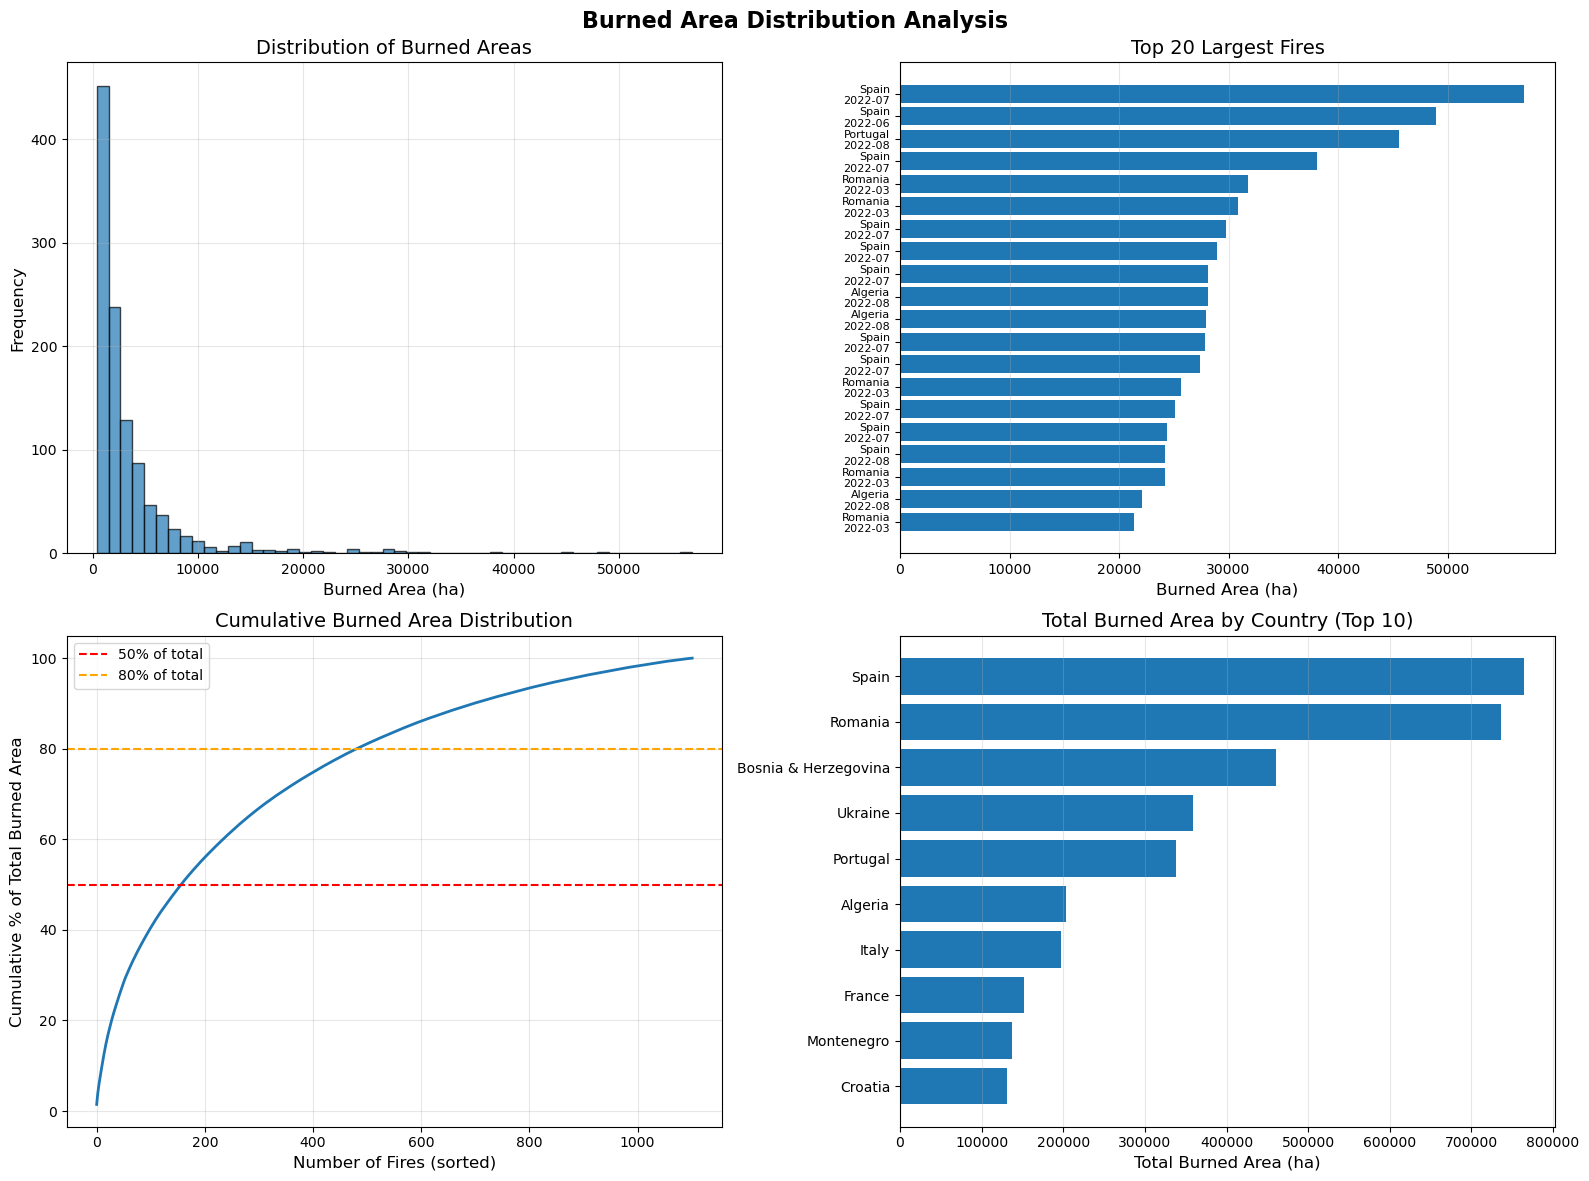

In [10]:
import matplotlib.pyplot as plt

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Burned Area Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Histogram of all burned areas
axes[0, 0].hist(df['burned_area_ha'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Burned Area (ha)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Distribution of Burned Areas', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# 2. Top 20 fires
top_20 = df_sorted.head(20)
axes[0, 1].barh(range(len(top_20)), top_20['burned_area_ha'])
axes[0, 1].set_yticks(range(len(top_20)))
axes[0, 1].set_yticklabels([f"{row['country']}\n{row['date'][:7]}" for _, row in top_20.iterrows()], fontsize=8)
axes[0, 1].set_xlabel('Burned Area (ha)', fontsize=12)
axes[0, 1].set_title('Top 20 Largest Fires', fontsize=14)
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Cumulative distribution
sorted_areas = df_sorted['burned_area_ha'].values
cumsum = np.cumsum(sorted_areas)
cumsum_pct = cumsum / cumsum[-1] * 100
axes[1, 0].plot(range(len(cumsum_pct)), cumsum_pct, linewidth=2)
axes[1, 0].axhline(y=50, color='r', linestyle='--', label='50% of total')
axes[1, 0].axhline(y=80, color='orange', linestyle='--', label='80% of total')
axes[1, 0].set_xlabel('Number of Fires (sorted)', fontsize=12)
axes[1, 0].set_ylabel('Cumulative % of Total Burned Area', fontsize=12)
axes[1, 0].set_title('Cumulative Burned Area Distribution', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Burned area by country (top countries)
country_totals = df.groupby('country')['burned_area_ha'].sum().sort_values(ascending=False).head(10)
axes[1, 1].barh(range(len(country_totals)), country_totals.values)
axes[1, 1].set_yticks(range(len(country_totals)))
axes[1, 1].set_yticklabels(country_totals.index)
axes[1, 1].set_xlabel('Total Burned Area (ha)', fontsize=12)
axes[1, 1].set_title('Total Burned Area by Country (Top 10)', fontsize=14)
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('burned_area_analysis.png', dpi=150, bbox_inches='tight')
print("✓ Saved visualization to: burned_area_analysis.png")
plt.show()